In [1]:
#install.packages('PerformanceAnalytics')
#install.packages("fGarch")
install.packages("evir")

library('quantmod')
library('fBasics')
library('PerformanceAnalytics')

Installing package into 'C:/Users/array/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'evir' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\array\AppData\Local\Temp\RtmpI5dZDC\downloaded_packages


Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: 'fBasics'


The following object is masked from 'package:TTR':

    volatility



Attaching package: 'PerformanceAnalytics'


The following objects are masked from 'package:fBasics':

    kurtosis, skewness


The following object is masked from 'package:graphics':

    legend




In [2]:
tick = c("^GSPC","^NSEI","^GSPTSE")
getSymbols(tick, from = "2009-01-03", to ='2020-03-01')
us_ret = diff(log(as.numeric(GSPC$GSPC.Adjusted[!is.na(GSPC$GSPC.Adjusted)])))
ind_ret = diff(log(as.numeric(NSEI$NSEI.Adjusted[!is.na(NSEI$NSEI.Adjusted)])))
can_ret = diff(log(as.numeric(GSPTSE$GSPTSE.Adjusted[!is.na(GSPTSE$GSPTSE.Adjusted)])))
nret = data.frame()
nret = cbind(-us_ret,-ind_ret,-can_ret)
colnames(nret) = c("USA","INDIA","CANADA")

head(nret)

Warning message:
"^NSEI contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."


[1] "GSPC"   "NSEI"   "GSPTSE"

Warning message in cbind(-us_ret, -ind_ret, -can_ret):
"number of rows of result is not a multiple of vector length (arg 2)"


USA,INDIA,CANADA
-0.007786737,0.002774963,-0.01989655
0.030469120,0.063802099,0.03773828
-0.003391316,0.016363780,-0.01093620
0.021533214,0.035390917,0.01490178
0.022822588,0.010203021,0.03265669
-0.001756515,-0.032384927,-0.01895869


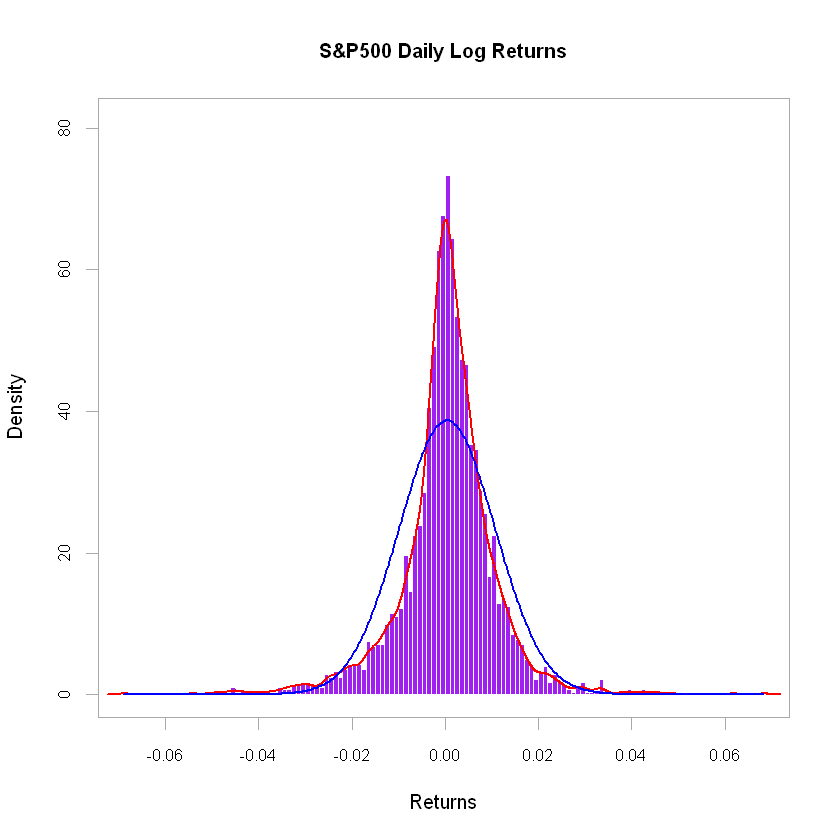

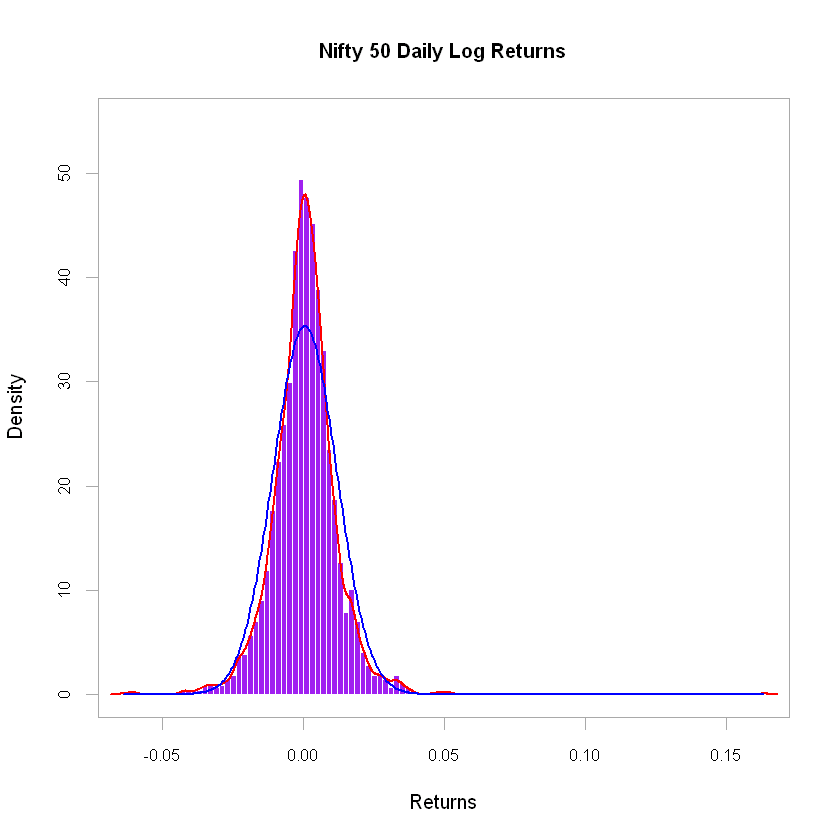

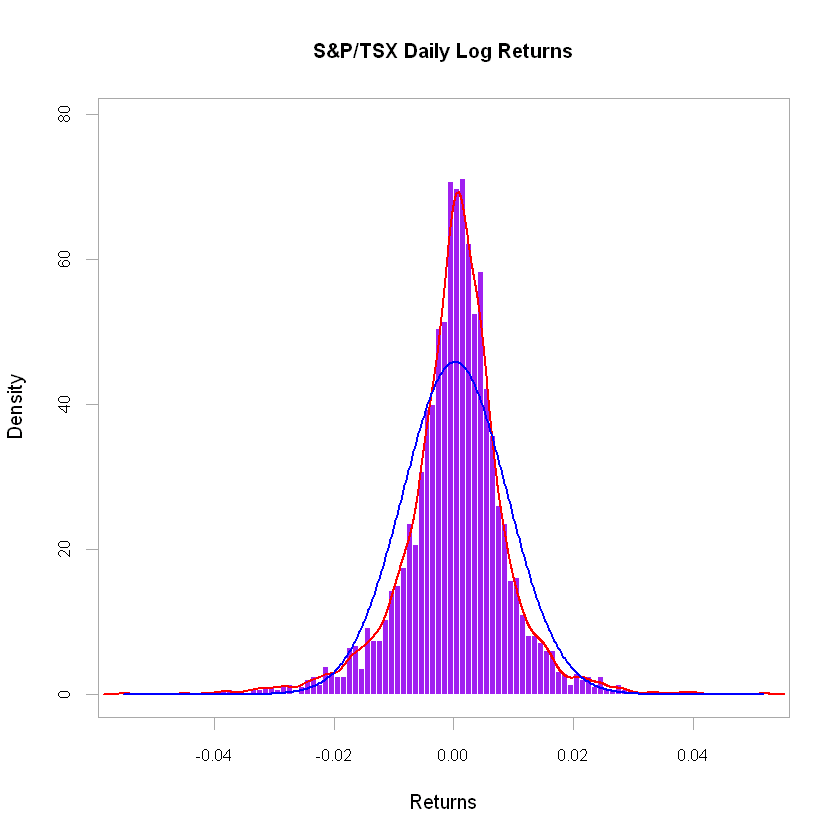

In [3]:
us_b = data.frame(basicStats(us_ret))
ind_b = data.frame(basicStats(ind_ret))
can_b = data.frame(basicStats(can_ret))
basic_stats = data.frame(us_b)
basic_stats = cbind(basic_stats,ind_b$ind_ret,can_b$can_ret)
names(basic_stats) = c("S&P 500","Nifty 50","S&P/TSX")
#write.csv(basic_stats, "C:\\Users\\Lighthouse\\Desktop\\basicstats.csv", row.names=TRUE)
chart.Histogram(us_ret,methods = c("add.density","add.normal"),
                colorset = c("purple","red","blue"),main = "S&P500 Daily Log Returns")
chart.Histogram(ind_ret,methods = c("add.density","add.normal"),
                colorset = c("purple","red","blue"),main = "Nifty 50 Daily Log Returns")
chart.Histogram(can_ret,methods = c("add.density","add.normal"),
                colorset = c("purple","red","blue"),main = "S&P/TSX Daily Log Returns")


In [4]:
source("RMfit.R")
v= c()
v_15 = c()
for (i in 1:3){
  m1 =RMfit(nret[,i])
  vpred=sqrt(m1$par[1]*(m1$volatility[2806])^2+(1-m1$par[1])*(nret[2806,i])^2)

  v[i] = vpred*qnorm(0.99)  #VaR at p=0.05    using  Vpred=0.007133031
    # 15-day holding period
  v_15[i] = sqrt(15)*vpred*qnorm(0.99) #note that qnorm(0.95)=1.645 
}
result = data.frame()
result = cbind(v,v_15)
rownames(result)  = c("USA","INDIA","CANADA")
colnames(result)  = c("RISKMETRICS_VAR","RISKMETRICS_VAR_15D")
result


Coefficient(s):
       Estimate  Std. Error  t value   Pr(>|t|)    
beta 0.92542863  0.00599368  154.401 < 2.22e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

 Volatility prediction:
     Orig     Vpred
[1,] 2806 0.0173217

 Risk measure based on RiskMetrics:
      prob        VaR         ES
[1,] 0.950 0.02849166 0.03572969
[2,] 0.990 0.04029629 0.04616603
[3,] 0.999 0.05352807 0.05832371

Coefficient(s):
       Estimate  Std. Error  t value   Pr(>|t|)    
beta 0.94529488  0.00601926  157.045 < 2.22e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

 Volatility prediction:
     Orig      Vpred
[1,] 2806 0.02257891

 Risk measure based on RiskMetrics:
      prob        VaR         ES
[1,] 0.950 0.03713900 0.04657380
[2,] 0.990 0.05252639 0.06017762
[3,] 0.999 0.06977407 0.07602521

Coefficient(s):
       Estimate  Std. Error  t value   Pr(>|t|)    
beta 0.91618925  0.00709706  129.094 < 2.22e-16 ***
---
Signif. codes:  0 '***' 0.001

,RISKMETRICS_VAR,RISKMETRICS_VAR_15D
USA,0.04029629,0.1560669
INDIA,0.05252639,0.2034338
CANADA,0.04605706,0.1783782


### Econometric modeling- GARCH11-norm #########

In [5]:
require(fGarch)
source('RMeasure.R')
v = c()
v_15 = c()
for (i in 1:3){
  
  m2=garchFit(~garch(1,1),data=nret[,i],trace=F)
  pm2=predict(m2,15)
  sigma=pm2[1,3]
  mu=pm2[1,1]
  a = data.frame(RMeasure(mu,sigma))
  v[i] = a[2,2] 
  v1=sqrt(sum(pm2$standardDeviation^2))
  b = data.frame(RMeasure(pm2$meanForecast[1]*15,v1))
  v_15[i] = b[2,2]
  
}
result = as.data.frame(cbind(result,v,v_15))
colnames(result)[3] = c("GARCH11norm_VAR")
colnames(result)[4] = c("GARCH11norm_VAR_15D")
result

Loading required package: fGarch

NOTE: Packages 'fBasics', 'timeDate', and 'timeSeries' are no longer
attached to the search() path when 'fGarch' is attached.

If needed attach them yourself in your R script by e.g.,
        require("timeSeries")


Attaching package: 'fGarch'


The following objects are masked from 'package:PerformanceAnalytics':

    ES, VaR


The following object is masked from 'package:TTR':

    volatility





 Risk Measures for selected probabilities: 
       prob        VaR         ES
[1,] 0.9500 0.03590115 0.04522136
[2,] 0.9900 0.05110165 0.05865995
[3,] 0.9990 0.06813983 0.07431505
[4,] 0.9999 0.08216465 0.08750579

 Risk Measures for selected probabilities: 
       prob       VaR        ES
[1,] 0.9500 0.1215839 0.1554692
[2,] 0.9900 0.1768480 0.2043275
[3,] 0.9990 0.2387932 0.2612443
[4,] 0.9999 0.2897829 0.3092015

 Risk Measures for selected probabilities: 
       prob        VaR         ES
[1,] 0.9500 0.03536494 0.04451393
[2,] 0.9900 0.05028620 0.05770565
[3,] 0.9990 0.06701138 0.07307316
[4,] 0.9999 0.08077855 0.08602158

 Risk Measures for selected probabilities: 
       prob       VaR        ES
[1,] 0.9500 0.1278947 0.1628581
[2,] 0.9900 0.1849172 0.2132711
[3,] 0.9990 0.2488335 0.2719989
[4,] 0.9999 0.3014456 0.3214821

 Risk Measures for selected probabilities: 
       prob        VaR         ES
[1,] 0.9500 0.03495169 0.04392850
[2,] 0.9900 0.04959213 0.05687194
[3,] 0.9990 0

,RISKMETRICS_VAR,RISKMETRICS_VAR_15D,GARCH11norm_VAR,GARCH11norm_VAR_15D
,<dbl>,<dbl>,<dbl>,<dbl>
USA,0.04029629,0.1560669,0.05110165,0.1768480
INDIA,0.05252639,0.2034338,0.05028620,0.1849172
CANADA,0.04605706,0.1783782,0.04959213,0.1827097


### Econometric modeling- GARCH11-std #########  

In [6]:
v = c()
v_15 = c()
for (i in 1:3){
  
  m3=garchFit(~garch(1,1),data=nret[,i],trace=F,cond.dist = "std")
  pm3=predict(m3,15)
  
  df=m3@fit$par[5]
  sigma=pm3[1,3]
  mu=pm3[1,1]
  
  c = data.frame(RMeasure(mu,sigma,cond.dist="std",df=df))
  v[i] = c[2,2] 
  v1=sqrt(sum(pm3$standardDeviation^2))
  d = data.frame(RMeasure(pm3$meanForecast[15],v1,cond.dist = "std",df=df))
  v_15[i] = d[2,2]
  
}
result = as.data.frame(cbind(result,v,v_15))
colnames(result)[5] = c("GARCH11std_VAR")
colnames(result)[6] = c("GARCH11std_VAR_15D")
result


 Risk Measures for selected probabilities: 
       prob        VaR         ES
[1,] 0.9500 0.03492579 0.05071124
[2,] 0.9900 0.05922334 0.07905163
[3,] 0.9990 0.10533298 0.13531165
[4,] 0.9999 0.17532325 0.22237895

 Risk Measures for selected probabilities: 
       prob       VaR        ES
[1,] 0.9500 0.1383819 0.1997711
[2,] 0.9900 0.2328744 0.3099861
[3,] 0.9990 0.4121936 0.5287798
[4,] 0.9999 0.6843838 0.8673822

 Risk Measures for selected probabilities: 
       prob        VaR         ES
[1,] 0.9500 0.03389972 0.04631696
[2,] 0.9900 0.05352925 0.06693285
[3,] 0.9990 0.08452655 0.10103292
[4,] 0.9999 0.12291357 0.14429386

 Risk Measures for selected probabilities: 
       prob       VaR        ES
[1,] 0.9500 0.1303232 0.1774146
[2,] 0.9900 0.2047666 0.2555986
[3,] 0.9990 0.3223213 0.3849203
[4,] 0.9999 0.4679009 0.5489838

 Risk Measures for selected probabilities: 
       prob        VaR         ES
[1,] 0.9500 0.03446458 0.04676840
[2,] 0.9900 0.05396655 0.06700876
[3,] 0.9990 0

,RISKMETRICS_VAR,RISKMETRICS_VAR_15D,GARCH11norm_VAR,GARCH11norm_VAR_15D,GARCH11std_VAR,GARCH11std_VAR_15D
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
USA,0.04029629,0.1560669,0.05110165,0.1768480,0.05922334,0.2328744
INDIA,0.05252639,0.2034338,0.05028620,0.1849172,0.05352925,0.2047666
CANADA,0.04605706,0.1783782,0.04959213,0.1827097,0.05396655,0.2076751


### Empirical quantiles ######### 

In [7]:
v = c()
v_15 = c()
for (i in 1:3){
    m4=quantile(nret[,i],c(0.99))
    v[i] = m4[1] 
}
result = as.data.frame(cbind(result,v))
colnames(result)[7] = c("EmpiricalQuant")


### Extreme value theory #########  
require(evir)
source("evtVaR.R")
v = c()
v_15 = c()
for (i in 1:3){
  
  m5=gev(nret[,i],block=21)
  
  e = as.data.frame(evtVaR(m5$par.ests[1],m5$par.ests[2],m5$par.ests[3],21,0.01))
  v[i] = e[1,1]
  v_15[i] = (15^m5$par.ests[1])*v[i]
  
  
}
result = as.data.frame(cbind(result,v,v_15))
colnames(result)[8] = c("EVT")
colnames(result)[9] = c("EVT_15D")
result

Loading required package: evir



       mu 
0.0263417 
        mu 
0.02697591 
        mu 
0.02202935 


,RISKMETRICS_VAR,RISKMETRICS_VAR_15D,GARCH11norm_VAR,GARCH11norm_VAR_15D,GARCH11std_VAR,GARCH11std_VAR_15D,EmpiricalQuant,EVT,EVT_15D
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
USA,0.04029629,0.1560669,0.05110165,0.1768480,0.05922334,0.2328744,0.03162947,0.02634170,0.04515733
INDIA,0.05252639,0.2034338,0.05028620,0.1849172,0.05352925,0.2047666,0.03274712,0.02697591,0.05210456
CANADA,0.04605706,0.1783782,0.04959213,0.1827097,0.05396655,0.2076751,0.02759183,0.02202935,0.03376588


### Generalized Pareto distribution ######### 

In [8]:
v = c()
v_15 = c()
for (i in 1:3){
  
  m6=gpd(nret[,i],0.01)  # Threshhold=0.01
  f = as.data.frame(riskmeasures(m6,c(0.99)))
  v[i] = f[1,2]
}
result = as.data.frame(cbind(result,v))
colnames(result)[10] = c("GPD")
result

,RISKMETRICS_VAR,RISKMETRICS_VAR_15D,GARCH11norm_VAR,GARCH11norm_VAR_15D,GARCH11std_VAR,GARCH11std_VAR_15D,EmpiricalQuant,EVT,EVT_15D,GPD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
USA,0.04029629,0.1560669,0.05110165,0.1768480,0.05922334,0.2328744,0.03162947,0.02634170,0.04515733,0.03165522
INDIA,0.05252639,0.2034338,0.05028620,0.1849172,0.05352925,0.2047666,0.03274712,0.02697591,0.05210456,0.03097107
CANADA,0.04605706,0.1783782,0.04959213,0.1827097,0.05396655,0.2076751,0.02759183,0.02202935,0.03376588,0.02655034


### POT: Peaks over Threshold ######### 

In [9]:
v = c()
v_15 = c()
for (i in 1:3){
  
  m7=pot(nret[,i],threshold=0.01)  # Threshold =0.01
  
  g = as.data.frame(riskmeasures(m7,c(0.99)))
  v[i] = g[1,2] 
}
result = as.data.frame(cbind(result,v))
colnames(result)[11] = c("POT")

result2 =  round(result * 100,2)
result2
#write.csv(result2, "C:\\Users\\Lighthouse\\Desktop\\result.csv", row.names=TRUE)

,RISKMETRICS_VAR,RISKMETRICS_VAR_15D,GARCH11norm_VAR,GARCH11norm_VAR_15D,GARCH11std_VAR,GARCH11std_VAR_15D,EmpiricalQuant,EVT,EVT_15D,GPD,POT
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
USA,4.03,15.61,5.11,17.68,5.92,23.29,3.16,2.63,4.52,3.17,3.17
INDIA,5.25,20.34,5.03,18.49,5.35,20.48,3.27,2.70,5.21,3.10,3.10
CANADA,4.61,17.84,4.96,18.27,5.40,20.77,2.76,2.20,3.38,2.66,2.66
